<a href="https://colab.research.google.com/github/DHKing7/dahyunk/blob/main/faster_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Install torch, torchvision, torchaudio
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.3 MB 25 kB/s 
     |████████████████████████████████| 12.7 MB 56.4 MB/s 
     |████████████████████████████████| 7.6 MB 8.0 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd drive/MyDrive/캡스톤디자인/2. filled

/content/drive/MyDrive/캡스톤디자인/2. filled


In [6]:
# Check to use CUDA
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')
  print('There are %d GPU(s) available.' %torch.cuda.device_count())
  print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
  print('No GPU available, using the CPU instead.')
  device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [7]:
import os
import random
import numpy as np
import shutil

print(len(os.listdir('Images/Images')))
print(len(os.listdir('Annotations')))

# !mkdir test_images
# !mkdir test_annotations


539
539


In [8]:
# random.seed(1234)
# idx = random.sample(range(674), 135)

# for img in np.array(sorted(os.listdir('Images/Images')))[idx]:
#   shutil.move('Images/Images/'+img, 'test_images/'+img)

# for annot in np.array(sorted(os.listdir('Annotations')))[idx]:
#   shutil.move('Annotations/'+annot, 'test_annotations/'+annot)

print(len(os.listdir('Images/Images')))
print(len(os.listdir('Annotations')))
print(len(os.listdir('test_images')))
print(len(os.listdir('test_annotations')))

539
539
135
135


In [9]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time
import json

In [10]:
def generate_box(obj):
    
    xmin = obj['bbox'][0]
    ymin = obj['bbox'][1]
    xmax = obj['bbox'][0]+obj['bbox'][2]
    ymax = obj['bbox'][1]+obj['bbox'][3]
    
    return [xmin, ymin, xmax, ymax]

adjust_label = 1

def generate_label(obj):

    if obj['category_id'] == 7: 
        return 7 + adjust_label

    elif obj['category_id'] == 8: 
        return 8 + adjust_label

    elif obj['category_id'] == 9:
      return 9 + adjust_label
    return 0 + adjust_label


def generate_target(file): 
    with open(f'{file}') as f:
        data = json.load(f)

        boxes = []
        labels = []
        for i in data['annotations']:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output1(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 7 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 8 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
        
        elif annotation['labels'][idx] == 9 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='b',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()



class PotholeDataset(object):

  def __init__(self, transforms, path):
    self.transforms = transforms
    self.path = path
    self.imgs = list(sorted(os.listdir(self.path)))
    

  def __getitem__(self, idx):
    file_image = self.imgs[idx]
    file_label = self.imgs[idx][:-4] +'_BBOX.json'
    img_path = os.path.join(self.path, file_image)

    if 'test' in self.path:
      label_path = os.path.join('test_annotations/', file_label)
    else:
      label_path = os.path.join('Annotations/', file_label)

    img = Image.open(img_path).convert('RGB')
    target = generate_target(label_path)

    if self.transforms is not None:
      img = self.transforms(img)

    return img, target

  def __len__(self):
    return len(self.imgs)

data_transform = transforms.Compose([
       transforms.ToTensor()
    ])

def collate_fn(batch):
  return tuple(zip(*batch))

dataset = PotholeDataset(data_transform, 'Images/Images/')
test_dataset = PotholeDataset(data_transform, 'test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size = 4, collate_fn = collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 2, collate_fn = collate_fn)

In [11]:
def get_model_instance_segmentation(num_classes):

  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  return model

In [12]:
model = get_model_instance_segmentation(11)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [13]:
torch.cuda.is_available()

True

In [14]:
num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.005)

In [15]:
print('________________train start___________________')
for epoch in range(num_epochs):
  start = time.time()
  model.train()
  i = 0
  epoch_loss = 0
  for imgs, annotations in data_loader:
    i+=1
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for  k, v in t.items()} for t in annotations]
    loss_dict = model(imgs, annotations)
    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    epoch_loss += losses
  
  print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time()-start}')

________________train start___________________
epoch : 1, Loss : 64.90094757080078, time : 284.6857957839966
epoch : 2, Loss : 44.269775390625, time : 165.01774740219116
epoch : 3, Loss : 37.696537017822266, time : 164.84953212738037
epoch : 4, Loss : 33.938758850097656, time : 165.2350356578827
epoch : 5, Loss : 33.05934143066406, time : 165.29402995109558
epoch : 6, Loss : 30.767436981201172, time : 165.4370129108429
epoch : 7, Loss : 29.52167320251465, time : 165.6166651248932
epoch : 8, Loss : 29.322677612304688, time : 165.89902091026306
epoch : 9, Loss : 29.03028678894043, time : 166.01910543441772
epoch : 10, Loss : 28.964263916015625, time : 166.15174794197083


In [16]:
torch.save(model.state_dict(),f'final_model_{num_epochs}.pt')

In [17]:
model.load_state_dict(torch.load(f'final_model_{num_epochs}.pt'))

<All keys matched successfully>

In [18]:
def make_prediction(model, img, threshold):
  model.eval()
  preds = model(img)
  for id in range(len(preds)):
    idx_list = []

    for idx, score in enumerate(preds[id]['scores']):
      if score > threshold:
        idx_list.append(idx)

    preds[id]['boxes'] = preds[id]['boxes'][idx_list].cpu()
    preds[id]['labels'] = preds[id]['labels'][idx_list]
    preds[id]['scores'] = preds[id]['scores'][idx_list]

  return preds

In [19]:
with torch.no_grad():

  for imgs, annotations in test_data_loader:
    imgs = list(img.to(device) for img in imgs)

    pred = make_prediction(model, imgs, 0.5)
    pred = pred
    print(pred)
    break
  

[{'boxes': tensor([[581.2921, 287.8104, 705.3075, 308.7943],
        [666.7890, 440.1424, 770.2387, 503.2347],
        [752.4807, 365.7619, 849.9418, 403.8351],
        [679.1507, 330.1475, 740.5151, 351.9464],
        [663.9040, 400.7193, 785.9069, 424.2407],
        [657.9136, 540.9077, 741.1047, 581.0438],
        [795.4471, 222.1035, 830.8431, 231.8857],
        [592.8264, 298.5280, 711.6920, 324.3105],
        [657.5591, 521.0289, 863.8832, 595.3963],
        [865.6594, 277.1857, 925.2506, 293.7050],
        [666.0831, 445.4802, 763.3535, 475.7821],
        [786.6331, 577.7824, 969.1761, 719.0061],
        [636.7753, 470.3796, 694.4943, 497.8550],
        [584.0864, 288.5119, 719.5865, 338.3960]]), 'labels': tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
       device='cuda:0'), 'scores': tensor([0.9489, 0.9290, 0.9072, 0.8422, 0.8201, 0.7500, 0.7266, 0.6842, 0.6243,
        0.5591, 0.5515, 0.5460, 0.5284, 0.5258], device='cuda:0')}, {'boxes': tensor([[483.9520, 

Target :  tensor([10])


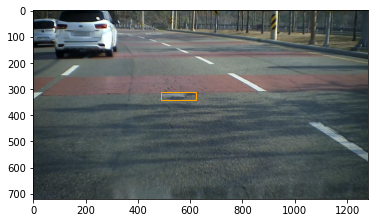

Prediction :  tensor([10, 10, 10, 10], device='cuda:0')


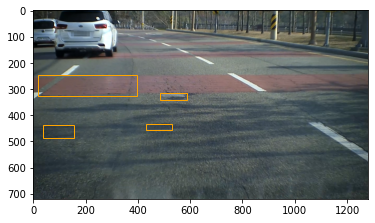

In [20]:
_idx = 1
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output1(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])
plot_image_from_output1(imgs[_idx], pred[_idx])

In [21]:
print(pred[_idx]['boxes'].to('cpu'))

tensor([[483.9520, 313.8069, 589.3976, 341.2144],
        [ 17.7251, 246.8553, 398.5491, 326.7288],
        [432.6186, 432.2274, 530.1444, 457.1349],
        [ 37.0059, 437.0316, 156.1434, 486.9171]])


In [22]:
print(annotations[_idx])

{'boxes': tensor([[487.5000, 310.5000, 621.5000, 342.5000]]), 'labels': tensor([10])}


In [23]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im,annot in tqdm(test_data_loader, position = 0, leave = True):
  im = list(img.to(device) for img in im)

  for t in annot:
    labels += t['labels']

  with torch.no_grad():
    preds_adj = make_prediction(model, im, 0.5)
    preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
    preds_adj_all.append(preds_adj)
    annot_all.append(annot)

100%|██████████| 68/68 [01:55<00:00,  1.69s/it]


In [24]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils

fatal: destination path 'Tutorial-Book-Utils' already exists and is not an empty directory.


In [25]:
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

/content/drive/MyDrive/캡스톤디자인/2. filled/Tutorial-Book-Utils


In [26]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
  sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.46965965002506105
AP : tensor([0.5585, 0.3808], dtype=torch.float64)
